## My Neural Network

In [14]:
import numpy as np
import scipy as sc

import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

## Datasets

In [15]:
input_dataset = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
output_dataset = np.array([[0], [1], [1], [0]])

## Activation functions

In [16]:
# function, derivate
sigm = lambda x : 1 / (1 + np.exp(-x))

sigmoid = (
    lambda x : sigm(x),
    lambda x : sigm(x) * (1 - sigm(x))
)

### Cost function

In [17]:
# function, derivate
mean_square_error = (
    lambda predictions, targets : np.mean((predictions - targets) ** 2),
    lambda predictions, targets : predictions - targets
)

def bin_cross_entropy(predictions, targets):
    return -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))

cross_entropy = (
    lambda predictions, targets : bin_cross_entropy(predictions, targets),
    lambda predictions, targets : predictions - targets
)


## Neural Network Layer class

In [18]:
class NeuralLayer:
    def __init__(self, num_connections_entering, num_neurons, activation_fn):
        self.activation_fn = activation_fn
        
        # create from -1 to 1
        self.bias = np.random.rand(1, num_neurons) * 2 - 1
        self.weights = np.random.rand(num_connections_entering, num_neurons) * 2 - 1
        
        self.num_connections_entering = num_connections_entering
        self.num_neurons = num_neurons

# Neuronal Network

In [19]:
np.random.seed(10)

def create_neural_network():
    neuralNetwork = [
        NeuralLayer(num_connections_entering=2, num_neurons=4, activation_fn=sigmoid),
        NeuralLayer(num_connections_entering=4, num_neurons=1, activation_fn=sigmoid),
    ]
    
    return neuralNetwork
    
XOR = create_neural_network()

def print_neural_network(neuralNetwork):
    list_indexes = list(range(neuralNetwork[0].num_connections_entering))
    inputs_names = list(map(lambda i: f"input {i + 1}", list_indexes))
    
    print(inputs_names, end="\n\n")
    
    for i, layer in enumerate(neuralNetwork):
        print(f"layer {i}: {layer.bias.shape[1]} neurons")
        print("weights")
        print(layer.weights, end="\n\n")
        print("bias")
        print(layer.bias, end="\n\n")
        
print_neural_network(XOR)

['input 1', 'input 2']

layer 0: 4 neurons
weights
[[-0.00298598 -0.55040671 -0.60387427  0.52106142]
 [-0.66177833 -0.82332037  0.37071964  0.90678669]]

bias
[[ 0.54264129 -0.9584961   0.26729647  0.49760777]]

layer 1: 1 neurons
weights
[[0.02438453]
 [0.62524192]
 [0.22505213]
 [0.44351063]]

bias
[[-0.99210347]]



In [20]:
def foward_pass(neural_network, inputs, print_it=True):
    input_to_layer = inputs
    steps = [(None, inputs)]
    
    for _, layer in enumerate(neural_network):
        ponderate_sum = input_to_layer @ layer.weights + layer.bias
        input_to_layer = activation = layer.activation_fn[0](ponderate_sum)
        
        steps.append((ponderate_sum, activation))
    
    if print_it:
        prediction = np.hstack((inputs, input_to_layer))
        print("Current behavior")
        print(prediction, end="\n\n")
    
    return steps

steps = foward_pass(XOR, input_dataset)

Current behavior
[[0.         0.         0.40129219]
 [0.         1.         0.40438821]
 [1.         0.         0.39082453]
 [1.         1.         0.39560569]]



In [21]:
def backpropagation(neural_network, inputs, outputs, cost_function, show, learning_rate = 3.2):
    steps = foward_pass(neural_network, inputs, show)
    deltas = [None] * len(neural_network)
    
    next_layer_weights = None
    num_layers, num_inputs = len(neural_network), inputs.shape[0]

    for i in reversed(range(num_layers)):
        ponderate_sum, activation = steps[i + 1]
        _, activation_last_layer = steps[i]
        
        if i == num_layers - 1:
            cost_activation = cost_function[1](activation, outputs)
        else:
            cost_activation = deltas[i + 1] @ next_layer_weights.T / num_inputs
            
        activation_ponderate = neural_network[i].activation_fn[1](ponderate_sum)
        deltas[i] = delta = cost_activation * activation_ponderate
        
        gradient_weights = (activation_last_layer.T @ delta) / num_inputs
        gradient_bias = np.mean(delta, axis=0, keepdims=True)
        
        next_layer_weights = neural_network[i].weights
        
        neural_network[i].bias -= learning_rate * gradient_bias
        neural_network[i].weights -= learning_rate * gradient_weights
        
    error = cost_function[0](steps[-1][1], outputs)
    return error

In [22]:
def show_step(neural_network, input_dataset, output_dataset, cost_function, show):
    error_before = backpropagation(neural_network, input_dataset, output_dataset, cost_function, show)
    print(f"current error = {error_before}")
    
    if show: 
        steps = foward_pass(neural_network, input_dataset, False)
        error_after = cost_function[0](steps[-1][1], output_dataset)
        
        print_neural_network(neural_network)
        
        print(f"new error = {error_after}")
        print(f"difference = {abs(error_before - error_after)}", end="\n\n")
        
    return error_before
        
x = show_step(XOR, input_dataset, output_dataset, cross_entropy, True)

Current behavior
[[0.         0.         0.40129219]
 [0.         1.         0.40438821]
 [1.         0.         0.39082453]
 [1.         1.         0.39560569]]

current error = 0.7153466422461845
['input 1', 'input 2']

layer 0: 4 neurons
weights
[[-0.00284884 -0.54864482 -0.6032559   0.52286221]
 [-0.66161431 -0.8220431   0.37118879  0.9080234 ]]

bias
[[ 0.54295789 -0.95694052  0.26838201  0.49941195]]

layer 1: 1 neurons
weights
[[0.06734319]
 [0.63471475]
 [0.2663149 ]
 [0.5068908 ]]

bias
[[-0.91411321]]

new error = 0.7009743904051282
difference = 0.014372251841056283



In [23]:
errors = []

In [24]:
@interact_manual(times = (200, 4500))
def trainXOR(times):
    global errors
    for i in range(times):
        error = show_step(XOR, input_dataset, output_dataset, cross_entropy, False)
        errors.append(error)
        

interactive(children=(IntSlider(value=2350, description='times', max=4500, min=200), Button(description='Run I…

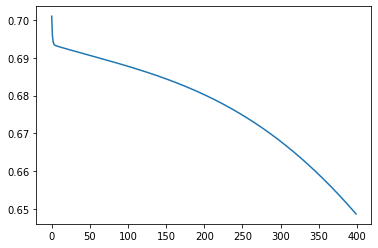

In [26]:
plt.plot(errors) 
plt.show() 

In [27]:
steps = foward_pass(XOR, input_dataset)

Current behavior
[[0.         0.         0.37999152]
 [0.         1.         0.53736796]
 [1.         0.         0.54997332]
 [1.         1.         0.59210657]]

